In [ ]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt

In [ ]:

def forcefield(x,x_0,k):
    return (x_0-x)*k
def timestep(x,force,Diffusion_particle,dt):
    return x+force*dt+rd.normal()*np.sqrt(2*Diffusion_particle*dt)
def make_trajectory(time,dt,k,Diffusion_particle,Diffusion_oscillator):
    x=rd.normal()
    x_0=0
    treyectory_particle=[x]
    treyectory_oscillator=[0]
    for i in range(int(time/dt)):
        force=forcefield(x,x_0,k)
        x_0+=rd.normal()*np.sqrt(2*Diffusion_oscillator*dt)
        x=timestep(x,force,Diffusion_particle,dt)
        treyectory_particle.append(x)
        treyectory_oscillator.append(x_0)
    return treyectory_particle,treyectory_oscillator
def mean_square_displacement(time_list,trajectory,sample_nuber=100,samplelength=100):
    sample_list=[]
    for i in range(sample_nuber):
        j=rd.randint(len(trajectory)-int(samplelength/dt))
        sample=trajectory[j:j+int(samplelength/dt)]
        beginning=sample[0]
        sample=[(s-beginning)**2 for s in sample]
        sample_list.append(sample)
    msd_trajectory=[np.mean([sample[i] for sample in sample_list]) for i in range(int(samplelength/dt)-1)]
    return    msd_trajectory   
def mean_back_realxation(dt, trajectory, Tao, timespan, sample_number,b_cutoff=0):
    forward_sampling = int(timespan / dt)
    backward_sampling = int(Tao / dt)
    mbr_trajectory = np.zeros(forward_sampling)
    num_cutoffs=0
    rng = np.random.default_rng()
    random_sample_list = rng.choice(
        len(trajectory) - forward_sampling - backward_sampling - 2,
        size=sample_number,
        replace=False,
    )
    random_sample_list = random_sample_list + backward_sampling + 1

    for j in random_sample_list:
        sample = trajectory[j : j + forward_sampling]
        x_0_mbr = sample[0]
        d_mbr = x_0_mbr - trajectory[j - backward_sampling]
        if abs(d_mbr)>b_cutoff:
            mbr_trajectory += (-(sample - x_0_mbr) / d_mbr) * 1 / sample_number
        else:
            num_cutoffs+=1

    return mbr_trajectory*(sample_number/(sample_number-num_cutoffs))
def analytical_mean_back_realxation(dt,time,k,Diffusion_particle,Diffusion_oscillator):
    time_list=np.linspace(0,time,int(time/dt))
    prefactor=1/2*(1-Diffusion_oscillator/Diffusion_particle)
    analytical_mbr=[prefactor*(1-np.exp(-k*t)) for t in time_list]
    return analytical_mbr


In [9]:
k=1
time=10000
dt=0.01
Diffusion_particle=1
Diffusion_oscillator=0

In [10]:
trajetreyectory_particle,treyectory_oscillatorctory=make_trajectory(time,dt,k,Diffusion_particle,Diffusion_oscillator)
time_list=np.linspace(0,time,int(time/dt)+1)

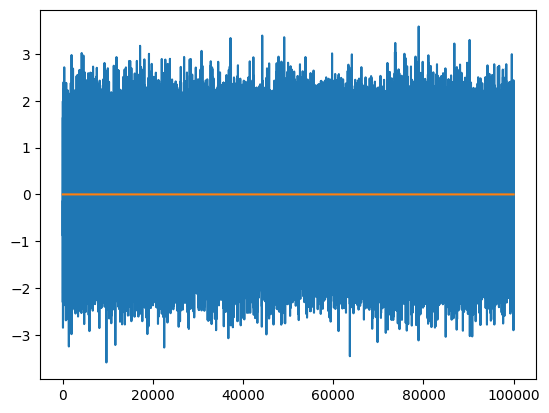

In [118]:
plt.plot(time_list,trajetreyectory_particle)
plt.plot(time_list,treyectory_oscillatorctory)

In [119]:
msd_samples=100000
msd_time=10
msd=mean_square_displacement(time_list,trajetreyectory_particle,msd_samples,msd_time)

In [120]:
plt.plot(np.linspace(0,msd_time,len(msd)),msd)

In [8]:
mbr_timespan=10
Tao=0.01
mbr_sample_nuber=100000
mbr=mean_back_realxation(dt,trajetreyectory_particle,Tao,mbr_timespan,mbr_sample_nuber,b_cutoff=0.1)
analytical_mbr=analytical_mean_back_realxation(dt,len(mbr)*dt,k,Diffusion_particle,Diffusion_oscillator)

In [9]:
plt.plot(np.linspace(0,mbr_timespan,len(mbr)),mbr)
plt.plot(np.linspace(0,mbr_timespan,len(mbr)),analytical_mbr)
plt.title("K:"+str(k)+" Tao:"+str(Tao))
plt.xlabel("time")
plt.ylabel("MBR")

Text(0, 0.5, 'MBR')

In [121]:
def inverse_cdf(p, mu, sigma):
    return norm.ppf(p, loc=mu, scale=sigma)
def mbr_matrix(trajectory,backward_sampling,forward_sampling,random_sample_list,bucket_edges):
    num_bins=len(bucket_edges)-1
    datapoints=np.zeros((num_bins,forward_sampling))
    n_samples_in_bucket=np.zeros(num_bins)

    for j in random_sample_list:
        sample = trajectory[j : j + forward_sampling]
        x_0_mbr = sample[0]
        d_mbr = x_0_mbr - trajectory[j - backward_sampling]

        index = np.searchsorted(bucket_edges, d_mbr) - 1
        mbr_sample=-(sample - x_0_mbr) / d_mbr
        n_samples_aready=n_samples_in_bucket[index]
        datapoints[index]=datapoints[index]*(n_samples_aready/(n_samples_aready+1))+mbr_sample/(n_samples_aready+1)
        n_samples_in_bucket[index]=n_samples_aready+1
    
    return datapoints

def mbr_via_weighted_mean(dt, trajectory, Tao, t, sample_number,num_bins=10, cutoff=0,sigma_b=0.1,N_bootstrap=30):
    probs = np.linspace(0, 0.5, num_bins+1)
    probs = probs[1:-1]  # Exclude 0 and 0.5 probabilities

    # Generate the series of N_bin points
    points = np.abs(inverse_cdf(probs, 0, sigma_b))

    # Count how often each sample lands in each bucket
    buckets = np.zeros(num_bins)
    bucket_edges = np.concatenate(([0], np.flip(points), [np.inf]))

    forward_sampling = int(t / dt)
    backward_sampling = int(Tao / dt)

    rng = np.random.default_rng()
    random_sample_list = rng.choice(
        len(trajectory) - forward_sampling - backward_sampling - 2,
        size=sample_number,
        replace=False,
    )
    random_sample_list = random_sample_list + backward_sampling + 1

    datapoint_list=[]
    for bucket_samples in np.array_split(random_sample_list,N_bootstrap):
        datapoint_list.append(mbr_matrix(trajectory,backward_sampling,forward_sampling,bucket_samples,bucket_edges))
    datapoint_list=np.array(datapoint_list)

    Bootsteap_means=np.zeros((num_bins,forward_sampling))
    Bootsteap_weightse=np.zeros((num_bins,forward_sampling))

    for i, j in np.ndindex(num_bins, forward_sampling):
        Bootsteap_means[i,j]=np.mean(datapoint_list[:,i,j])
        Bootsteap_weightse[i,j]=1/np.var(datapoint_list[:,i,j])

    weighted_mean=np.zeros(forward_sampling)

    for i in range(forward_sampling):
        
        weighted_mean[i]=np.average(Bootsteap_means[:,i],weights=Bootsteap_weightse[:,i])
 
    return weighted_mean, Bootsteap_weightse



In [122]:
mbr_timespan=10
Tao=0.01
mbr_sample_nuber=1000000
mbr=mean_back_realxation(dt,trajetreyectory_particle,Tao,mbr_timespan,mbr_sample_nuber,b_cutoff=0.005)
analytical_mbr=analytical_mean_back_realxation(dt,len(mbr)*dt,k,Diffusion_particle,Diffusion_oscillator)

In [123]:
N_bootstrap=100
num_bins=10
weighted_mean,weightlist=mbr_via_weighted_mean(dt, trajetreyectory_particle, Tao, mbr_timespan, mbr_sample_nuber,N_bootstrap=N_bootstrap,num_bins=num_bins)

C:\Users\jschulz\AppData\Local\Temp\ipykernel_16552\3373809329.py:53: RuntimeWarning: divide by zero encountered in scalar divide
  Bootsteap_weightse[i,j]=1/np.var(datapoint_list[:,i,j])
C:\Users\jschulz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:551: RuntimeWarning: invalid value encountered in multiply
  avg = avg_as_array = np.multiply(a, wgt,


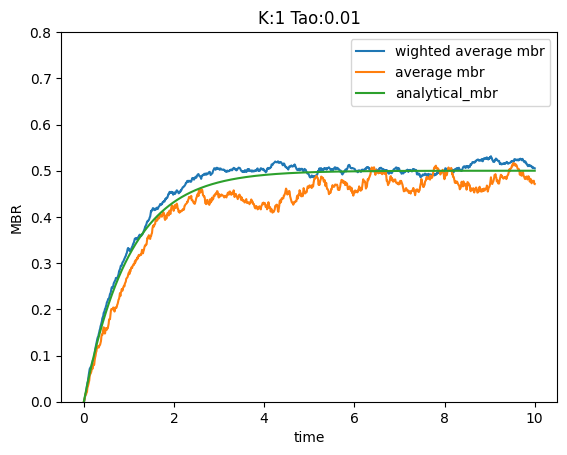

In [124]:
x_values = np.linspace(0, mbr_timespan, len(mbr))

#for i in range(num_bins):
#    plt.errorbar(x_values, Bootsteap_means[i], yerr=np.sqrt(Bootsteap_variance[i]),
#                 alpha=0.5)

# Plot mbr and analytical_mbr with labels
plt.plot(x_values, weighted_mean, label='wighted average mbr')
plt.plot(x_values, mbr, label='average mbr')
plt.plot(x_values, analytical_mbr, label='analytical_mbr')

plt.title("K:" + str(k) + " Tao:" + str(Tao))
plt.xlabel("time")
plt.ylabel("MBR")
plt.ylim((0, 0.8))

# Add legend to show labels
plt.legend()

plt.show()

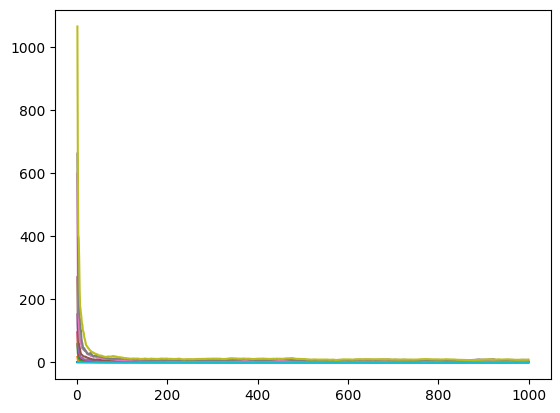

In [115]:
plt.plot(weightlist.T)

In [84]:
range(9,8)

range(9, 8)

In [62]:
plt.plot(np.linspace(0,mbr_timespan,len(mbr)),Bootsteap_means.T)
plt.ylim((0,0.8))
plt.plot(np.linspace(0,mbr_timespan,len(mbr)),mbr)
plt.plot(np.linspace(0,mbr_timespan,len(mbr)),analytical_mbr)
plt.title("K:"+str(k)+" Tao:"+str(Tao))
plt.xlabel("time")
plt.ylabel("MBR")

SyntaxError: expression cannot contain assignment, perhaps you meant "=="? (239949081.py, line 1)

In [148]:


n_bins = 100
plot_range=100
n_b_bins=4
std_b=0.1


fig, axs = plt.subplots(1, 3, figsize=(20, 5))

labels = ['{}$\sigma_b$<b<{}$\sigma_b$'.format(i,i+1) for i in range(n_b_bins)]
labels.reverse()
for i in range(3):
    # Plot the histograms
    batches=[[datapoint for b, datapoint in mbr_data[i] if std_b*j <= b <= std_b*(j+1)]for j in range(n_b_bins)]
    batches.reverse()
    n, bins, patches = axs[i].hist(batches, n_bins, density=True, histtype='bar', stacked=True, range=(-plot_range, plot_range), label=labels)

    # Set the titles
    axs[i].set_title('t=' + str(sampleing_times[i]))

# Add a legend outside of the plots
axs[-1].legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize='x-large')

plt.tight_layout()
plt.show()


In [291]:
T=10
sampeling_times=[i*dt for i in range(1,int(T/dt))]
mbr_timespan=10
Tao=0.01
mbr_sample_nuber=100000
wm_mbr_tray= [mbr_via_weighted_mean(dt, trajetreyectory_particle, Tao, t, mbr_sample_nuber,num_bins=10,cutoff=0.1) for t in sampeling_times]

#analytical_mbr=analytical_mean_back_realxation(dt,len(mbr)*dt,k,Diffusion_particle,Diffusion_oscillator)

C:\Users\jschulz\AppData\Local\Temp\ipykernel_11940\919665021.py:30: RuntimeWarning: divide by zero encountered in scalar divide
  batch_weights=[N/var for N, var in zip(batch_members,variances)]
C:\Users\jschulz\AppData\Local\Temp\ipykernel_11940\919665021.py:33: RuntimeWarning: invalid value encountered in scalar multiply
  mbr=sum([np.mean(batch)*weight for batch, weight in zip(batches,batch_weights)])/sum(batch_weights)


In [292]:
mbr_timespan=10
Tao=0.01
mbr_sample_nuber=100000
mbr=mean_back_realxation(dt,trajetreyectory_particle,Tao,mbr_timespan,mbr_sample_nuber,b_cutoff=0.1)
analytical_mbr=analytical_mean_back_realxation(dt,len(mbr)*dt,k,Diffusion_particle,Diffusion_oscillator)

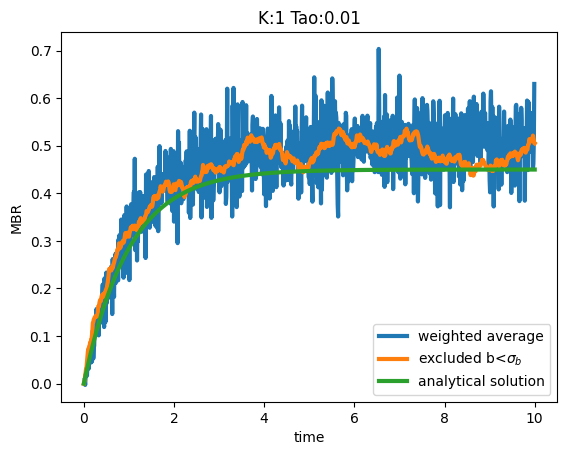

In [293]:
lnw=3
plt.plot(sampeling_times,wm_mbr_tray,label='weighted average',linewidth=lnw)
plt.plot(np.linspace(0,mbr_timespan,len(mbr)),mbr,label='excluded b<$\sigma_b$',linewidth=lnw)
plt.plot(np.linspace(0,mbr_timespan,len(mbr)),analytical_mbr,label='analytical solution',linewidth=lnw)
plt.title("K:"+str(k)+" Tao:"+str(Tao))
plt.xlabel("time")
plt.ylabel("MBR")
plt.legend()

In [274]:
center,batch_weights, variances,batch_members, mbr_values, batches=visualization(dt, trajetreyectory_particle, Tao, 2, mbr_sample_nuber,num_bins=10)
measured_mbr=sum([bar_value*weight for bar_value, weight in zip(mbr_values,batch_weights)])/sum(batch_weights)

Text(0, 0.5, 'weight')

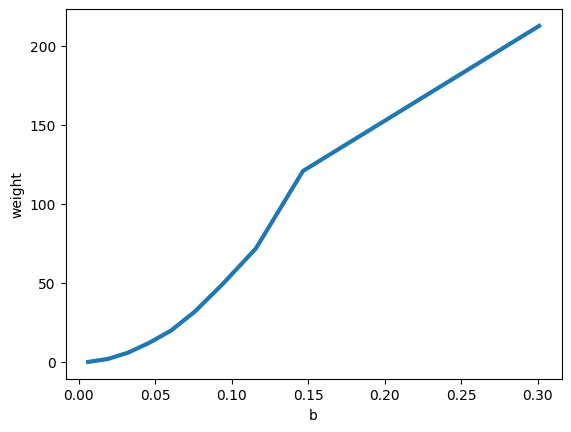

In [275]:
plt.plot(center,batch_weights,linewidth=lnw)
plt.xlabel("b")
plt.ylabel("weight")

Text(0, 0.5, 'MBR')

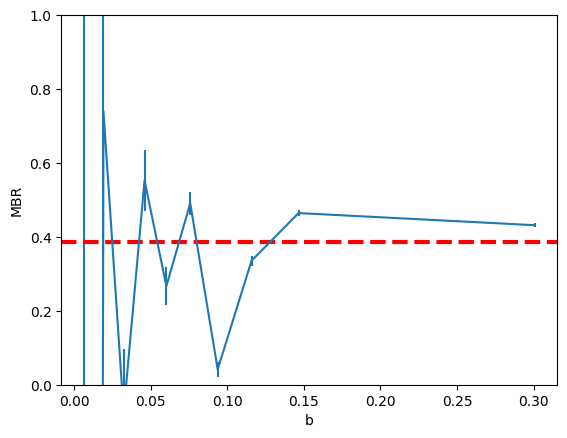

In [276]:
#plt.plot(center,mbr_values,linewidth=lnw)
plt.errorbar(center,mbr_values,[1/w for w in batch_weights])
plt.axhline(y=measured_mbr, color='r', linestyle='--', linewidth=lnw) 
plt.ylim((0,1))
plt.plot()
plt.xlabel("b")
plt.ylabel("MBR")

(0.0, 300.0)

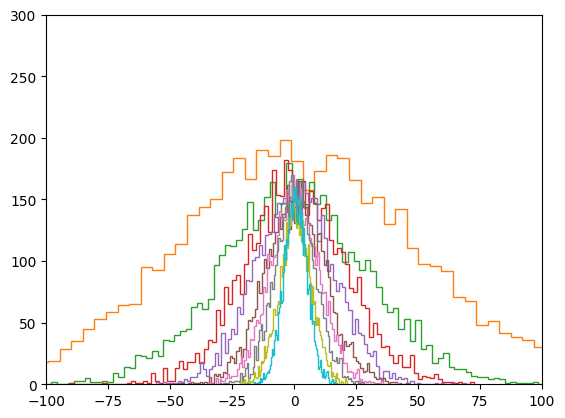

In [288]:
for x in batches:
    counts, bins = np.histogram(x,100)
    plt.stairs(counts, bins)
plt.xlim((-100,100))
plt.ylim((0,300))